## Autoregression option

An autoregression model makes an assumption that the observations at previous time steps (t-1, t-2 etc) are useful to predict the value at the next time step (t+1):

**X(*t+1*) = b0 + b1 \* X(*t-1*) + b2 \* X(*t-2*) + ... + bn \* X(*t - n*) + e**

The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling. If all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable.

In [250]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

### Univariate Time Series

In [174]:
series = pd.read_csv('monthly_sales.csv', index_col='Month', parse_dates=True, header=0)

In [356]:
split_point = len(series) - 20
dataset, validation = series[:split_point], series[split_point:]

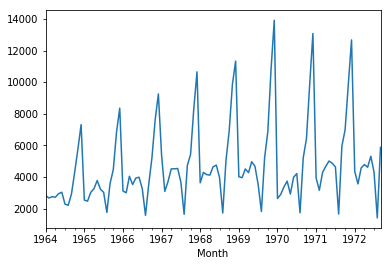

In [357]:
series['Sales'].plot()

Time series is non-stationary, so it should be transformed to stationary using differencing:

In [358]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [370]:
X = dataset['Sales']
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = dataset.index[months_in_year:]

To test if new series is stationary, we can use Dickey-Fuller test:

In [371]:
result = adfuller(stationary)
print('Statistic: %f' % result[0])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Statistic: -6.877238
Critical Values:
	1%: -3.525
	5%: -2.903
	10%: -2.589


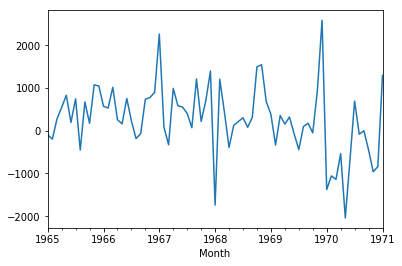

In [372]:
stationary.plot()
plt.show()

This dataset can now be used as an input to the ARIMA model. The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

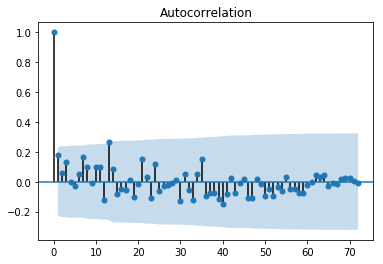

In [362]:
plot_acf(stationary)
plt.show()

In [363]:
def inverse_difference(history, yhat, interval=1):
    """
    Invert differenced value
    """
    return yhat + history[-interval]

In [368]:
X = dataset['Sales']
y = validation['Sales']

# walk-forward validation
history = [x for x in X]
predictions = list()

# rolling forecasts
for i in range(len(y)):
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(y[i])

mse = mean_squared_error(validation, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 604.560


In [376]:
predicted_series = pd.Series(predictions, index=y.index)

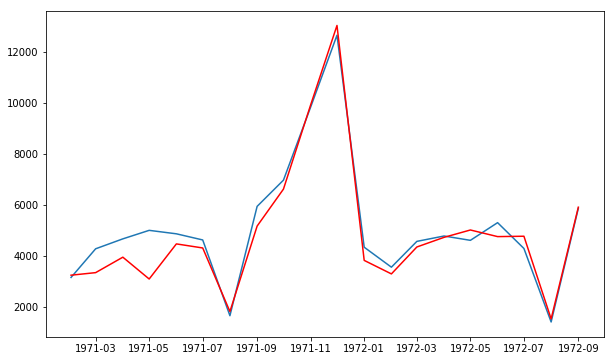

In [377]:
plt.figure(figsize=(10,6))
plt.plot(y)
plt.plot(predicted_series, color='red')
plt.show()

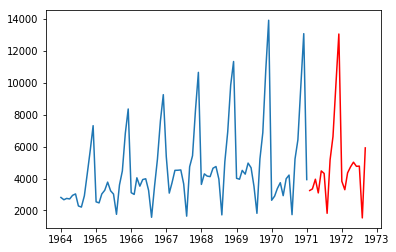

In [378]:
plt.plot(X)
plt.plot(predicted_series, color='red')
plt.show()

Result are great! But what if we need to make forecast based on multiple factors. 

## Multivariate Time Series – VAR

For problem with multiple variables AR models can't be used. Vector Auto Regression (VAR) - one of the most commonly used methods for multivariate time series forecasting. 

For this example Air Quality dataset was used.

In [196]:
df = pd.read_csv('AirQualityUCI.csv', parse_dates=[['Date', 'Time']], sep=';')

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 16 columns):
Date_Time        9471 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(10), object(6)
memory usage: 1.2+ MB


Last 2 columns can be removed, because they entirely nulls. For testing purpose remove all non-float fields also.

In [198]:
drop_list = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']
df = df.drop(drop_list, axis=1)
cols = df.columns

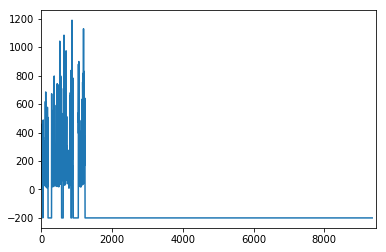

In [199]:
df['NMHC(GT)'].plot()

Here we remove part of rows with null values.

In [246]:
df = df[300:550]
df['Date_Time'] = pd.to_datetime(df['Date_Time'] , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

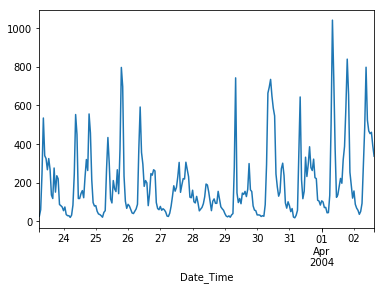

In [247]:
data['NMHC(GT)'].plot()

In [186]:
data.head(2) # cleaned dataset

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
Date_Time,,,,,,,,
2004-03-23 06:00:00,909.0,26.0,567.0,33.0,1542.0,47.0,1287.0,418.0
2004-03-23 07:00:00,1061.0,60.0,745.0,103.0,1178.0,88.0,1429.0,616.0


In [187]:
split_point = int(0.8*(len(data)))
train = data[:split_point]
test = data[split_point:]

In [242]:
model = VAR(endog=train.values)
model_fit = model.fit()

In [244]:
prediction = model_fit.forecast(model_fit.y, steps=len(test))

In [245]:
for i, col in enumerate(cols):
    print('rmse value for', col, 'is : ', sqrt(mean_squared_error(prediction[i], test.values[i])))

rmse value for Date_Time is :  100.25557965107843
rmse value for PT08.S1(CO) is :  168.86830386652574
rmse value for NMHC(GT) is :  58.037682569715095
rmse value for PT08.S2(NMHC) is :  79.15570832110978
rmse value for NOx(GT) is :  106.53490699101461
rmse value for PT08.S3(NOx) is :  89.07312043664454
rmse value for NO2(GT) is :  46.985703224390356
rmse value for PT08.S4(NO2) is :  92.97851484411905
rmse value for PT08.S5(O3) is :  110.58865711994214
